## Importing Necessary Packages 

In [239]:
import pandas as pd 

import numpy as np

from sklearn.feature_selection import SelectKBest

from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering

from sklearn.feature_selection import chi2

from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder

from sklearn.metrics import silhouette_score, adjusted_rand_score, confusion_matrix 

from sklearn.decomposition import PCA

from sklearn.utils import resample 

## Reading the data 

In [242]:
diabetes_data = pd.read_csv('C:/Users/techa/Desktop/diabetic_data.csv')

In [244]:
diabetes_data.shape

(101766, 50)

In [246]:
diabetes_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      101766 non-null  object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    101766 non-null  object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                101766 non-null  object
 11  medical_specialty         101766 non-null  object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            101766 non-null  int64 
 14  num_

Redundant information such as **`encounter_id`**, and **`patient_nbr`** add no value to the clustering model and so they were removed from the dataset.

In [248]:
diabetes_data = diabetes_data.drop(['encounter_id', 'patient_nbr', ], axis = 1)

In [250]:
diabetes_data['readmitted'].unique()

array(['NO', '>30', '<30'], dtype=object)

This needs to be label encoded when the clustering happens.

In [253]:
diabetes_data.isnull().sum()

race                            0
gender                          0
age                             0
weight                          0
admission_type_id               0
discharge_disposition_id        0
admission_source_id             0
time_in_hospital                0
payer_code                      0
medical_specialty               0
num_lab_procedures              0
num_procedures                  0
num_medications                 0
number_outpatient               0
number_emergency                0
number_inpatient                0
diag_1                          0
diag_2                          0
diag_3                          0
number_diagnoses                0
max_glu_serum               96420
A1Cresult                   84748
metformin                       0
repaglinide                     0
nateglinide                     0
chlorpropamide                  0
glimepiride                     0
acetohexamide                   0
glipizide                       0
glyburide     

Two variables **`max_glu_serum`** and **`A1Cresult`** have high missing values and so rather than imputing those values, they were dropped from the dataset instead. While is possible to impute missing values using median imputation for numerical variables, and mode imputation for categorical variables, this would generate synthetic data which was ultimately avoided for this project.

In [256]:
diabetes_data.drop(['max_glu_serum', 'A1Cresult'], axis = 1)

race  gender      age weight  admission_type_id  \
0             Caucasian  Female   [0-10)      ?                  6   
1             Caucasian  Female  [10-20)      ?                  1   
2       AfricanAmerican  Female  [20-30)      ?                  1   
3             Caucasian    Male  [30-40)      ?                  1   
4             Caucasian    Male  [40-50)      ?                  1   
...                 ...     ...      ...    ...                ...   
101761  AfricanAmerican    Male  [70-80)      ?                  1   
101762  AfricanAmerican  Female  [80-90)      ?                  1   
101763        Caucasian    Male  [70-80)      ?                  1   
101764        Caucasian  Female  [80-90)      ?                  2   
101765        Caucasian    Male  [70-80)      ?                  1   

        discharge_disposition_id  admission_source_id  time_in_hospital  \
0                             25                    1                 1   
1                              1                    7                 3   
2                              1                    7                 2   
3                              1                    7                 2   
4                              1                    7                 1   
...                          ...                  ...               ...   
101761                         3                    7                 3   
101762                         4                    5                 5   
101763                         1                    7                 1   
101764                         3                    7                10   
101765                         1                    7                 6   

       payer_code         medical_specialty  ...  citoglipton  insulin  \
0               ?  Pediatrics-Endocrinology  ...           No       No   
1               ?                         ?  ...           No       Up   
2               ?                         ?  ...           No       No   
3               ?                         ?  ...           No       Up   
4               ?                         ?  ...           No   Steady   
...           ...                       ...  ...          ...      ...   
101761         MC                         ?  ...           No     Down   
101762         MC                         ?  ...           No   Steady   
101763         MC                         ?  ...           No     Down   
101764         MC           Surgery-General  ...           No       Up   
101765          ?                         ?  ...           No       No   

        glyburide-metformin  glipizide-metformin  glimepiride-pioglitazone  \
0                        No                   No                        No   
1                        No                   No                        No   
2                        No                   No                        No   
3                        No                   No                        No   
4                        No                   No                        No   
...                     ...                  ...                       ...   
101761                   No                   No                        No   
101762                   No                   No                        No   
101763                   No                   No                        No   
101764                   No                   No                        No   
101765                   No                   No                        No   

        metformin-rosiglitazone metformin-pioglitazone change diabetesMed  \
0                            No                     No     No          No   
1                            No                     No     Ch         Yes   
2                            No                     No     No         Yes   
3                            No                     No     Ch         Yes   
4                            No                     No     Ch     

Moreover, the dataset has missing values in terms of question marks as well. The question marks are first changed into Nan (null) for easier processing. Columns with the question marks will then be dropped rather than imputed. This is to avoid generating synthetic data based on imputation as that can affect the clustering of the dataset.

In [259]:
diabetes_data.replace('?', pd.NA, inplace=True)

In [261]:
diabetes_data.isnull().sum()

race                         2273
gender                          0
age                             0
weight                      98569
admission_type_id               0
discharge_disposition_id        0
admission_source_id             0
time_in_hospital                0
payer_code                  40256
medical_specialty           49949
num_lab_procedures              0
num_procedures                  0
num_medications                 0
number_outpatient               0
number_emergency                0
number_inpatient                0
diag_1                         21
diag_2                        358
diag_3                       1423
number_diagnoses                0
max_glu_serum               96420
A1Cresult                   84748
metformin                       0
repaglinide                     0
nateglinide                     0
chlorpropamide                  0
glimepiride                     0
acetohexamide                   0
glipizide                       0
glyburide     

Looking at the dataset, we can see that variables `race`, `weight`, `diag_1`, `diag_2`, `diag_3`, `max_glu_serum`, and `A1Cresult` will be dropped from the dataset. 

In [263]:
diabetes_data = diabetes_data.drop(['max_glu_serum', 'A1Cresult', 'race', 'diag_1', 'diag_2', 'diag_3', 'payer_code', 'weight', 'medical_specialty'], axis = 1)

In [267]:
diabetes_data.shape

(101766, 39)

In [265]:
diabetes_data.isnull().sum()

gender                      0
age                         0
admission_type_id           0
discharge_disposition_id    0
admission_source_id         0
time_in_hospital            0
num_lab_procedures          0
num_procedures              0
num_medications             0
number_outpatient           0
number_emergency            0
number_inpatient            0
number_diagnoses            0
metformin                   0
repaglinide                 0
nateglinide                 0
chlorpropamide              0
glimepiride                 0
acetohexamide               0
glipizide                   0
glyburide                   0
tolbutamide                 0
pioglitazone                0
rosiglitazone               0
acarbose                    0
miglitol                    0
troglitazone                0
tolazamide                  0
examide                     0
citoglipton                 0
insulin                     0
glyburide-metformin         0
glipizide-metformin         0
glimepirid

There are no null values in the dataset which means we have successfully removed variables with high null values. This removes the need for imputation.

In [32]:
diabetes_data.nunique()

gender                        3
age                          10
admission_type_id             8
discharge_disposition_id     26
admission_source_id          17
time_in_hospital             14
num_lab_procedures          118
num_procedures                7
num_medications              75
number_outpatient            39
number_emergency             33
number_inpatient             21
number_diagnoses             16
metformin                     4
repaglinide                   4
nateglinide                   4
chlorpropamide                4
glimepiride                   4
acetohexamide                 2
glipizide                     4
glyburide                     4
tolbutamide                   2
pioglitazone                  4
rosiglitazone                 4
acarbose                      4
miglitol                      4
troglitazone                  2
tolazamide                    3
examide                       1
citoglipton                   1
insulin                       4
glyburid

Variables with only 1 unique value and they are also categorical mean that they add no significance to the predictive performance. They would be considered redundant information which will actually affect the clustering based on our target variable. Variables such as `examide` and `citoglipton` are dropped from the data frame for this reason. 

In [35]:
diabetes_data = diabetes_data.drop(['examide', 'citoglipton'], axis = 1)

In [37]:
diabetes_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 37 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   gender                    101766 non-null  object
 1   age                       101766 non-null  object
 2   admission_type_id         101766 non-null  int64 
 3   discharge_disposition_id  101766 non-null  int64 
 4   admission_source_id       101766 non-null  int64 
 5   time_in_hospital          101766 non-null  int64 
 6   num_lab_procedures        101766 non-null  int64 
 7   num_procedures            101766 non-null  int64 
 8   num_medications           101766 non-null  int64 
 9   number_outpatient         101766 non-null  int64 
 10  number_emergency          101766 non-null  int64 
 11  number_inpatient          101766 non-null  int64 
 12  number_diagnoses          101766 non-null  int64 
 13  metformin                 101766 non-null  object
 14  repa

### Identification of numerical features 

In [40]:
numerical_features = list(diabetes_data.drop(['readmitted'], axis = 1).select_dtypes('int64').columns)
print(numerical_features)

['admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses']


While admission_type_id and discharge_disposition_id and admission_source_id may have int64 as their data type, they are multi-class categorical variables. And so they were dropped from the numerical_features list and added to the categorical_features list below. Moreover, the different types of medicine administered to patients are also binary variables and not numerical variables so they were dropped from this list as well.

In [43]:
numerical_features.remove('admission_type_id')
numerical_features.remove('discharge_disposition_id')
numerical_features.remove('admission_source_id')

In [45]:
#the names of numerical features within the dataset 
print(numerical_features)

['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses']


### Identification of binary variables and changing them to 0-1 variables

Binary variables are identified and changed to 0-1 for the clustering. 

In [49]:
categorical_features = list(diabetes_data.drop(['readmitted'], axis = 1).select_dtypes('object').columns)

binary_features = [col for col in categorical_features
 if diabetes_data[col].nunique() == 2]
print(f'binary features: {binary_features}')

binary features: ['acetohexamide', 'tolbutamide', 'troglitazone', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone', 'change', 'diabetesMed']


In [51]:
diabetes_data['acetohexamide'].unique()

array(['No', 'Steady'], dtype=object)

In [53]:
diabetes_data['tolbutamide'].unique()

array(['No', 'Steady'], dtype=object)

In [55]:
diabetes_data['troglitazone'].unique()

array(['No', 'Steady'], dtype=object)

In [57]:
diabetes_data['glipizide-metformin'].unique()

array(['No', 'Steady'], dtype=object)

In [59]:
diabetes_data['glimepiride-pioglitazone'].unique()

array(['No', 'Steady'], dtype=object)

In [61]:
diabetes_data['metformin-rosiglitazone'].unique()

array(['No', 'Steady'], dtype=object)

In [63]:
diabetes_data['metformin-pioglitazone'].unique()

array(['No', 'Steady'], dtype=object)

In [65]:
acetohexamide = {'No':0, 'Steady':1}

#Changing the values to 0-1
diabetes_data['acetohexamide'] = diabetes_data['acetohexamide'].map(acetohexamide)
diabetes_data['tolbutamide'] = diabetes_data['tolbutamide'].map(acetohexamide)
diabetes_data['troglitazone'] = diabetes_data['troglitazone'].map(acetohexamide)
diabetes_data['glipizide-metformin'] = diabetes_data['glipizide-metformin'].map(acetohexamide)
diabetes_data['glimepiride-pioglitazone'] = diabetes_data['glimepiride-pioglitazone'].map(acetohexamide)
diabetes_data['metformin-rosiglitazone'] = diabetes_data['metformin-rosiglitazone'].map(acetohexamide)
diabetes_data['metformin-pioglitazone'] = diabetes_data['metformin-pioglitazone'].map(acetohexamide)

In [67]:
diabetes_data['change'].unique()

array(['No', 'Ch'], dtype=object)

In [69]:
change = {'No':0, 'Ch':1}

diabetes_data['change'] = diabetes_data['change'].map(change)

In [71]:
diabetes_data['diabetesMed'].unique()

array(['No', 'Yes'], dtype=object)

In [73]:
diabetesMed = {'No':0, 'Yes':1}
diabetes_data['diabetesMed'] = diabetes_data['diabetesMed'].map(diabetesMed)

## Handling variables of multi-class 

In [76]:
multi_class = [col for col in categorical_features
 if col not in binary_features]
print(f'Multi-class features: {multi_class}')

Multi-class features: ['gender', 'age', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'glipizide', 'glyburide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'tolazamide', 'insulin', 'glyburide-metformin']


In [78]:
#adding admission_type_id, discharge_disposition_id, and admission_source_id to multi-class as well
multi_class.append('admission_type_id')
multi_class.append('discharge_disposition_id')
multi_class.append('admission_source_id')

In [80]:
for col in multi_class:
    print(f'{col}:', diabetes_data[col].unique())

gender: ['Female' 'Male' 'Unknown/Invalid']
age: ['[0-10)' '[10-20)' '[20-30)' '[30-40)' '[40-50)' '[50-60)' '[60-70)'
 '[70-80)' '[80-90)' '[90-100)']
metformin: ['No' 'Steady' 'Up' 'Down']
repaglinide: ['No' 'Up' 'Steady' 'Down']
nateglinide: ['No' 'Steady' 'Down' 'Up']
chlorpropamide: ['No' 'Steady' 'Down' 'Up']
glimepiride: ['No' 'Steady' 'Down' 'Up']
glipizide: ['No' 'Steady' 'Up' 'Down']
glyburide: ['No' 'Steady' 'Up' 'Down']
pioglitazone: ['No' 'Steady' 'Up' 'Down']
rosiglitazone: ['No' 'Steady' 'Up' 'Down']
acarbose: ['No' 'Steady' 'Up' 'Down']
miglitol: ['No' 'Steady' 'Down' 'Up']
tolazamide: ['No' 'Steady' 'Up']
insulin: ['No' 'Up' 'Steady' 'Down']
glyburide-metformin: ['No' 'Steady' 'Down' 'Up']
admission_type_id: [6 1 2 3 4 5 8 7]
discharge_disposition_id: [25  1  3  6  2  5 11  7 10  4 14 18  8 13 12 16 17 22 23  9 20 15 24 28
 19 27]
admission_source_id: [ 1  7  2  4  5  6 20  3 17  8  9 14 10 22 11 25 13]


For the age variable, it is easier to handle just two cases of Male or Female. Therefore, Unknown/Invalid will be removed from the dataset.

In [83]:
diabetes_data = diabetes_data[diabetes_data['gender'] != 'Unknown/Invalid']

In [85]:
#Convert categorical variables to numerical values (label encoding)
encoder = LabelEncoder()

for col in multi_class:
    diabetes_data[col] = encoder.fit_transform(diabetes_data[col])

In [87]:
#checking if label encoding works 
for col in multi_class:
    print(diabetes_data[col].unique())

[0 1]
[0 1 2 3 4 5 6 7 8 9]
[1 2 3 0]
[1 3 2 0]
[1 2 0 3]
[1 2 0 3]
[1 2 0 3]
[1 2 3 0]
[1 2 3 0]
[1 2 3 0]
[1 2 3 0]
[1 2 3 0]
[1 2 0 3]
[0 1 2]
[1 3 2 0]
[1 2 0 3]
[5 0 1 2 3 4 7 6]
[23  0  2  5  1  4 10  6  9  3 13 17  7 12 11 15 16 20 21  8 19 14 22 25
 18 24]
[ 0  6  1  3  4  5 14  2 13  7  8 12  9 15 10 16 11]


## Dimensionality Reduction Method 

In [90]:
#features used for the clustering 
X = diabetes_data.drop(['readmitted'], axis = 1)

#target column for clustering 
y = diabetes_data['readmitted']

#encoding the target variable
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

In [202]:
print(X.shape)

(101763, 36)


### Correlation Matrix of Numerical Variables

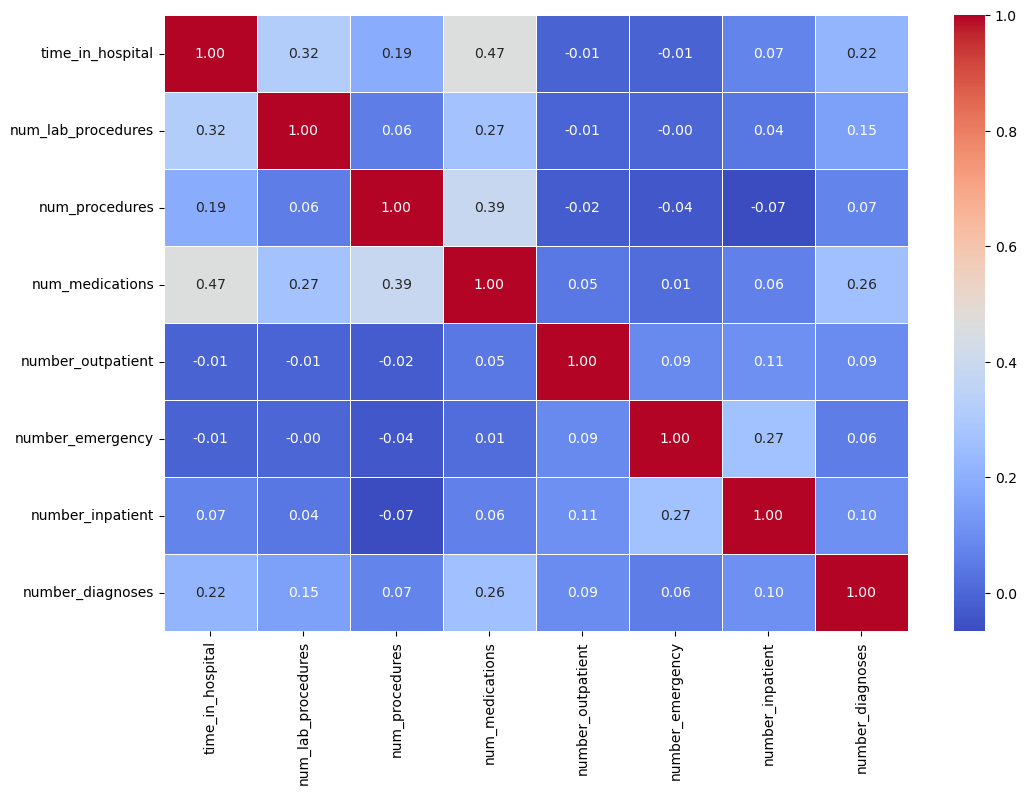

In [93]:
# Compute correlation matrix for numerical features
corr_matrix = X[numerical_features].corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.show()

None of the numerical features have high correlation and so correlation feature selection method will not be used to reduce this dataset's dimensionality.

In [96]:
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler

#Standardize the data before using Lasso
scaler = StandardScaler()
X[numerical_features] = scaler.fit_transform(X[numerical_features])

print(X.head())

   gender  age  admission_type_id  discharge_disposition_id  \
0       0    0                  5                        23   
1       0    1                  0                         0   
2       0    2                  0                         0   
3       1    3                  0                         0   
4       1    4                  0                         0   

   admission_source_id  time_in_hospital  num_lab_procedures  num_procedures  \
0                    0         -1.137665           -0.106531       -0.785382   
1                    6         -0.467666            0.808376       -0.785382   
2                    6         -0.802665           -1.631377        2.145823   
3                    6         -0.802665            0.045953       -0.199141   
4                    6         -1.137665            0.401751       -0.785382   

   num_medications  number_outpatient  ...  troglitazone  tolazamide  insulin  \
0        -1.848261          -0.291466  ...             0   

### Lasso Regression: Feature Selection

### Finding the Optimal Alpha for Regularization Strength

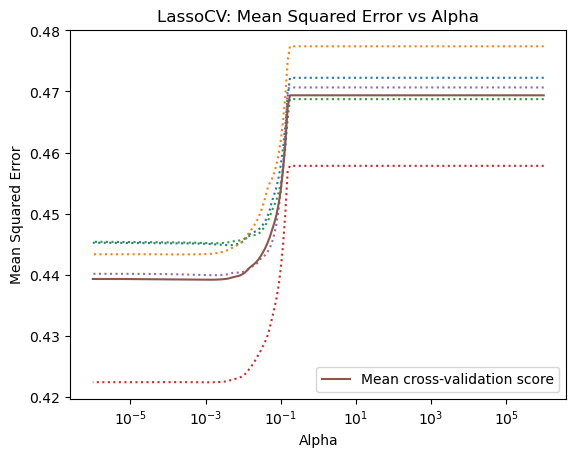

In [105]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LassoCV

#Create a range of alpha values to test
alphas = np.logspace(-6, 6, 200)

#Fit LassoCV with these alpha values
lasso = LassoCV(alphas=alphas, cv=5)
lasso.fit(X, y_encoded)

# Plot the cross-validation mean score against alpha values
plt.plot(lasso.alphas_, lasso.mse_path_, ':')
plt.plot(lasso.alphas_, lasso.mse_path_.mean(axis=-1), label='Mean cross-validation score')
plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('Mean Squared Error')
plt.title('LassoCV: Mean Squared Error vs Alpha')
plt.legend()
plt.show()

Chose the alpha where the mean error is the lowest which is the elbow point of the plot. This is roughly around alpha = 0.01 and this regularization strength also prevents the lasso regression from reducing every feature to 0. Hence, this was chosen as the ideal alpha.  

In [109]:
#Apply Lasso regression
lasso = Lasso(alpha=0.01)  # You can tune alpha for regularization strength
lasso.fit(X, y_encoded)

#Get features with non-zero coefficients
selected_features = X.columns[lasso.coef_ != 0]
print(f"Selected features based on Lasso: {selected_features}")

Selected features based on Lasso: Index(['age', 'admission_source_id', 'time_in_hospital', 'num_lab_procedures',
       'num_procedures', 'num_medications', 'number_outpatient',
       'number_emergency', 'number_inpatient', 'number_diagnoses',
       'diabetesMed'],
      dtype='object')


In [111]:
X_selected_df = X[selected_features]
print(X_selected_df.head())

   age  admission_source_id  time_in_hospital  num_lab_procedures  \
0    0                    0         -1.137665           -0.106531   
1    1                    6         -0.467666            0.808376   
2    2                    6         -0.802665           -1.631377   
3    3                    6         -0.802665            0.045953   
4    4                    6         -1.137665            0.401751   

   num_procedures  num_medications  number_outpatient  number_emergency  \
0       -0.785382        -1.848261          -0.291466         -0.212623   
1       -0.785382         0.243390          -0.291466         -0.212623   
2        2.145823        -0.371802           1.286722         -0.212623   
3       -0.199141        -0.002687          -0.291466         -0.212623   
4       -0.785382        -0.986993          -0.291466         -0.212623   

   number_inpatient  number_diagnoses  diabetesMed  
0         -0.503285         -3.321656            0  
1         -0.503285         

### Sampling the Data to Avoid High Computational Complexity 

In [114]:
## sampling observations from X_selected_df to avoid long computation time
X_resampled, y_resampled = resample(X_selected_df, y_encoded, n_samples=int(0.1 * len(X_selected_df)), random_state=42)

# Check the shape of the resampled data
print(f"Resampled X shape: {X_resampled.shape}")
print(f"Resampled y shape: {y_resampled.shape}")

Resampled X shape: (10176, 11)
Resampled y shape: (10176,)


## Applying K-Means Clustering 

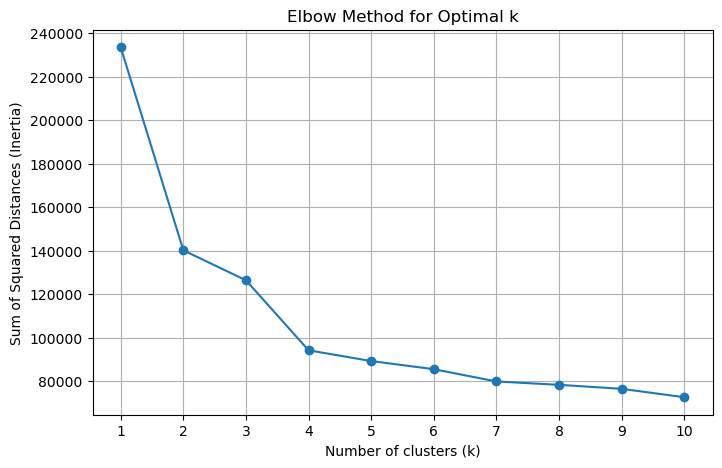

In [117]:
#Elbow Method to find optimal k
sse = []
k_range = range(1, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
    kmeans.fit(X_resampled)
    sse.append(kmeans.inertia_)

# Plot Elbow Method
plt.figure(figsize=(8, 5))
plt.plot(k_range, sse, marker='o')
plt.title("Elbow Method for Optimal k")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Sum of Squared Distances (Inertia)")
plt.xticks(k_range)
plt.grid(True)
plt.show()

In [119]:
#Optimal number of clusters at 2 
kmeans = KMeans(n_clusters = 2, random_state=42)

labels = kmeans.fit_predict(X_resampled)

#Comparing clusters with true labels using Adjusted Rand Index (ARI)
ari = adjusted_rand_score(y_resampled, labels)
print(f'Adjusted Rand Index (ARI): {ari}') 

print(f'Silhouette Score: {silhouette_score(X_resampled, labels)}')

Adjusted Rand Index (ARI): -0.006837585736240999
Silhouette Score: 0.3920493011140542


## Comparing KMeans Result with Original if There Was No Feature Selection

In [669]:
kmeans_original = KMeans(n_clusters = 2, random_state = 42)
labels_original = kmeans.fit_predict(X)

print(f'Adjusted Rand Index (ARI): {adjusted_rand_score(y, labels_original)}')
print(f'Silhouette Score: {silhouette_score(X, labels_original)}')

Adjusted Rand Index (ARI): -0.007966354379833169
Silhouette Score: 0.20363116062740919


Without feature selection, computing the silhouette score also took very long as it fitted every feature in the entire dataset. This is not ideal and also we can see that the ARI index is only slightly higher and Silhouette Score is low. Hence feature selection is needed to find the best features in this dataset.

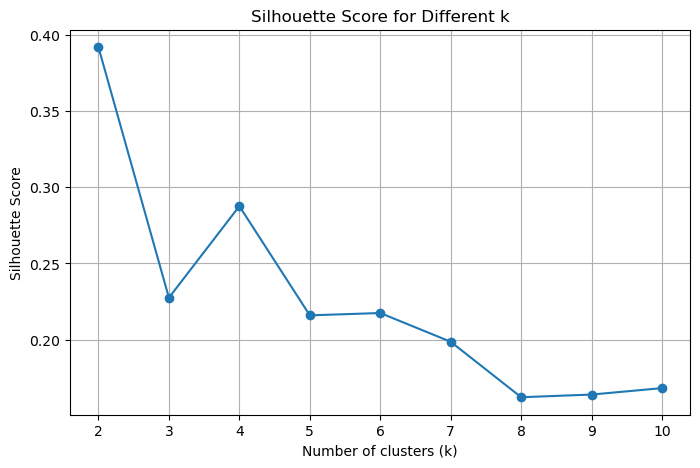

In [422]:
#Silhouette scores for different k
silhouette_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
    labels = kmeans.fit_predict(X_resampled)
    silhouette_scores.append(silhouette_score(X_resampled, labels))

# Plot Silhouette Scores
plt.figure(figsize=(8, 5))
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.title("Silhouette Score for Different k")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()

In [423]:
print(silhouette_scores)

[0.3920493011140542, 0.22748333203564727, 0.28765562901647296, 0.21591028877698107, 0.21743981940815565, 0.19854387077898894, 0.1621244708123954, 0.1638695589540956, 0.16811735435743602]


### Visualizing the KMeans Clustering Using PCA, MDS, TSNE

### 3D PCA

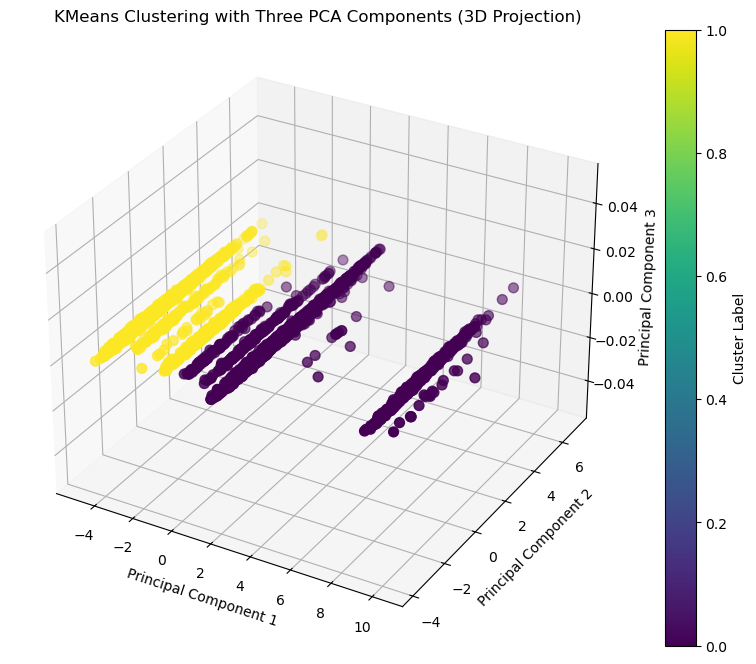

In [277]:
pca_3d = PCA(n_components= 3)
X_pca_3d = pca.fit_transform(X_resampled)

from mpl_toolkits.mplot3d import Axes3D

#3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(X_pca_3d[:, 0], X_pca_3d[:, 1], c= labels, cmap='viridis', marker='o', s=50)
plt.title("KMeans Clustering with Three PCA Components (3D Projection)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
ax.set_zlabel("Principal Component 3")
plt.colorbar(sc, label='Cluster Label')
plt.show()

### 2D PCA

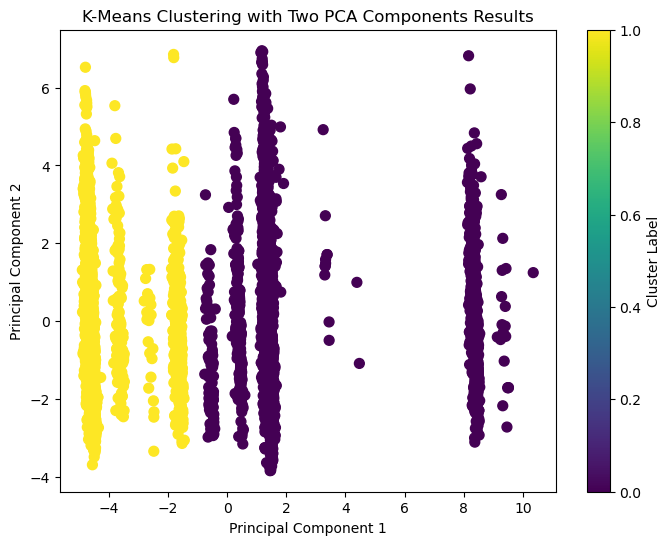

In [281]:
pca_2d = PCA(n_components = 2)
X_pca_2d = pca.fit_transform(X_resampled)

#Plot the clusters
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', marker='o', s=50)
plt.title("K-Means Clustering with Two PCA Components Results")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(label='Cluster Label')
plt.show()

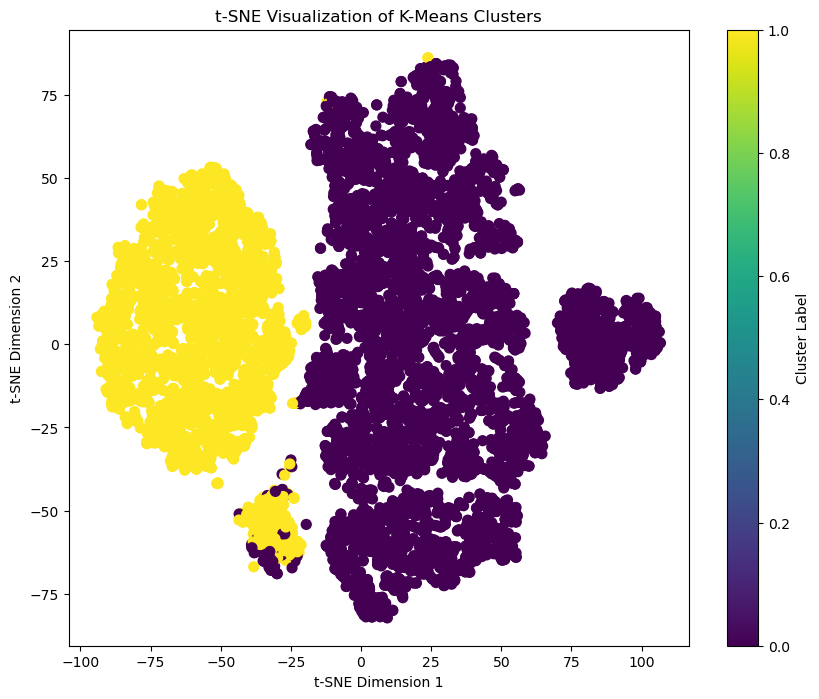

In [125]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_resampled)

# Plotting the 2D t-SNE representation with cluster labels
plt.figure(figsize=(10, 8))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c= labels, cmap='viridis', s=50)
plt.title('t-SNE Visualization of K-Means Clusters')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.colorbar(label='Cluster Label')  # Colorbar to show the cluster labels
plt.show()

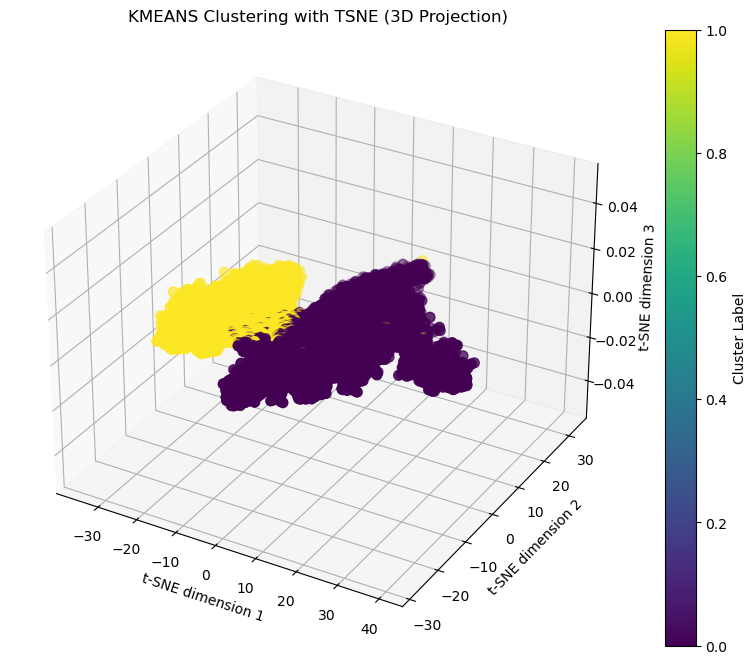

In [200]:
tsne = TSNE(n_components = 3, random_state = 42)
X_tsne_3d = tsne.fit_transform(X_resampled)

#3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(X_tsne_3d[:, 0], X_tsne_3d[:, 1], c= labels, cmap='viridis', marker='o', s=50)
plt.title("KMEANS Clustering with TSNE (3D Projection)")
plt.xlabel("t-SNE dimension 1")
plt.ylabel("t-SNE dimension 2")
ax.set_zlabel("t-SNE dimension 3")
plt.colorbar(sc, label='Cluster Label')
plt.show()

In [ ]:
from sklearn.manifold import MDS
import matplotlib.pyplot as plt

mds = MDS(n_components=2) 
X_mds = mds.fit_transform(X_resampled) 

## Alternative Clustering: DBSCAN

### Default DBSCAN 

In [610]:
dbscan = DBSCAN(eps= 0.5, min_samples= 5)

# Fit the model on the data
labels_db = dbscan.fit_predict(X_resampled)

In [612]:
#changing X_resampled into DataFrame format 
X_resampled_df = pd.DataFrame(X_resampled)
print(X_resampled_df.columns)

Index(['age', 'admission_source_id', 'time_in_hospital', 'num_lab_procedures',
       'num_procedures', 'num_medications', 'number_outpatient',
       'number_emergency', 'number_inpatient', 'number_diagnoses',
       'diabetesMed'],
      dtype='object')


In [614]:
#Computing silhouette score for first DBSCAN model
mask = labels != -1
sil_score = silhouette_score(X_resampled[mask], labels_db[mask])
print(sil_score)

-0.5212593924028719


In [615]:
#Comparing clusters with true labels using Adjusted Rand Index (ARI)
ari = adjusted_rand_score(y_resampled, labels_db)
print(f'Adjusted Adjusted Rand Index (ARI): {ari}') 

Adjusted Adjusted Rand Index (ARI): -0.0019229301712078294


### Finding the best DBSCAN Silhouette Score and ARI

In [628]:
best_score = -1
best_ari = -1
best_eps = 0
best_min_samples = 0

# Loop over different values of eps and min_samples
for eps in [i * 0.5 for i in range(1, 11)]:  # eps from 0.5 to 5 (in steps of 0.5)
    for min_samples in range(5, 51, 5):  # min_samples from 5 to 50 with step size 5
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        y_dbscan = dbscan.fit_predict(X_resampled)
        
        # Compute Silhouette Score, but handle the case when DBSCAN labels noise (-1)
        if len(set(y_dbscan)) > 1:  # Only compute silhouette score if there are at least two clusters
            score = silhouette_score(X_resampled, y_dbscan)
        else:
            score = -1  # If DBSCAN labels everything as noise, set the score to -1
        
        # Compute the ARI score
        ari = adjusted_rand_score(y_resampled, y_dbscan)
        
        # Update the best score and parameters if conditions are met
        if score > best_score and ari > best_ari:
            best_score = score
            best_ari = ari
            best_eps = eps
            best_min_samples = min_samples

print(f"Optimal eps: {best_eps} and optimal min_samples: {best_min_samples}")
print(f"Best Silhouette Score: {best_score:.3f} and Best ARI: {best_ari:.3f}")

Optimal eps: 2.0 and optimal min_samples: 10
Best Silhouette Score: 0.327 and Best ARI: 0.018


## Optimal DBSCAN Diagrams

In [134]:
from sklearn.cluster import DBSCAN

optimal_dbscan = DBSCAN(eps= 2, min_samples= 10)

# Fit the model on the data
optimal_db = optimal_dbscan.fit_predict(X_resampled)

## 2D Visualization of DBSCAN Clustering with Two Principal Components 1 vs 2

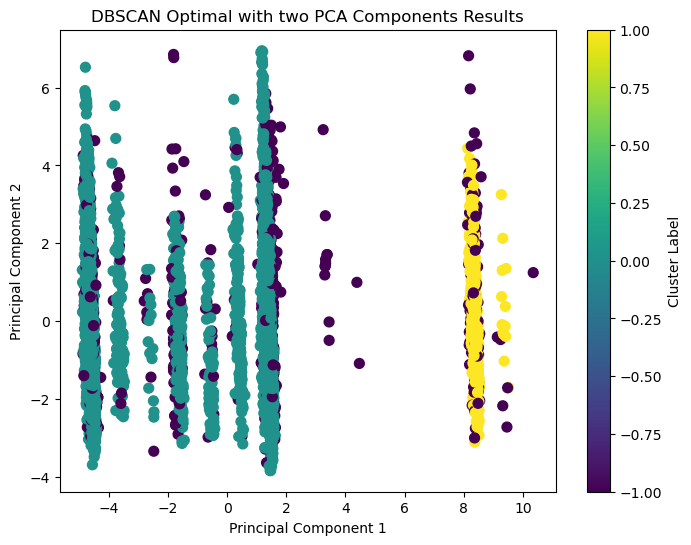

In [269]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_resampled)

#Plot the clusters
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c= optimal_db, cmap='viridis', marker='o', s=50)
plt.title("DBSCAN Optimal with two PCA Components Results")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(label='Cluster Label')
plt.show()

## 3D Visualization of DBSCAN Clustering with Three PCA Components

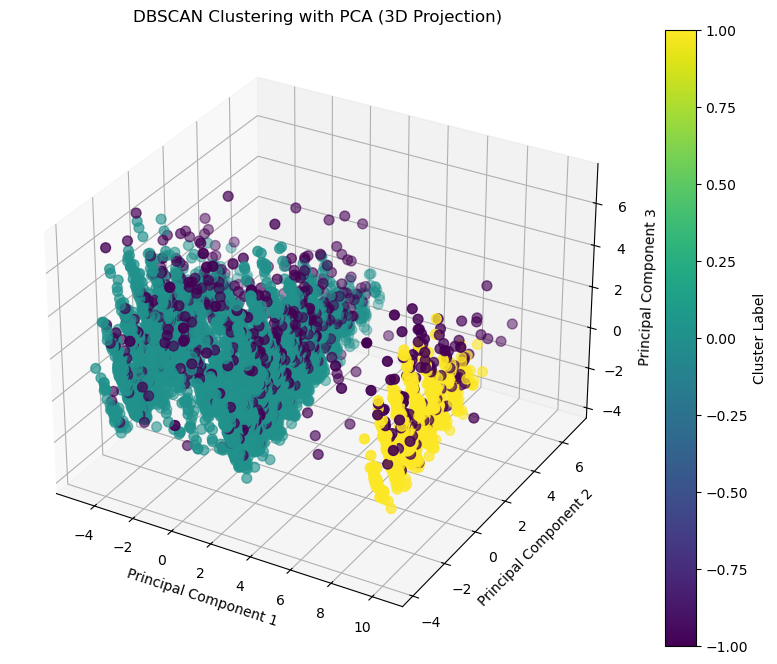

In [271]:
from mpl_toolkits.mplot3d import Axes3D

#Reduce the data to 3D using PCA
pca_3d = PCA(n_components=3)
X_pca_3d = pca_3d.fit_transform(X_resampled)

#3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(X_pca_3d[:, 0], X_pca_3d[:, 1], X_pca_3d[:, 2], c= optimal_db, cmap='viridis', marker='o', s=50)
plt.title("DBSCAN Clustering with PCA (3D Projection)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
ax.set_zlabel("Principal Component 3")
plt.colorbar(sc, label='Cluster Label')
plt.show()

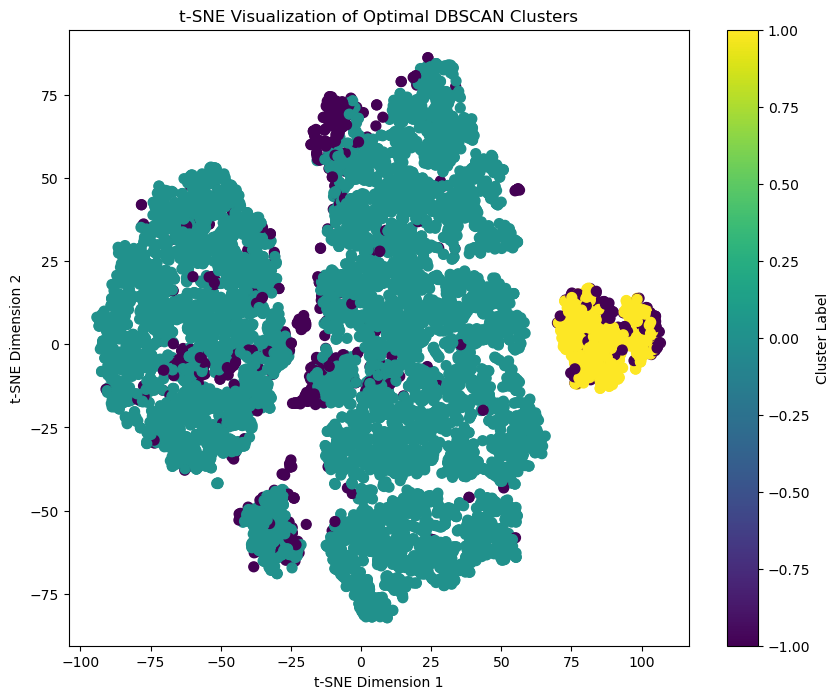

In [273]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_resampled)

# Plotting the 2D t-SNE representation with cluster labels
plt.figure(figsize=(10, 8))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c= optimal_db, cmap='viridis', s=50)
plt.title('t-SNE Visualization of Optimal DBSCAN Clusters')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.colorbar(label='Cluster Label')  # Colorbar to show the cluster labels
plt.show()

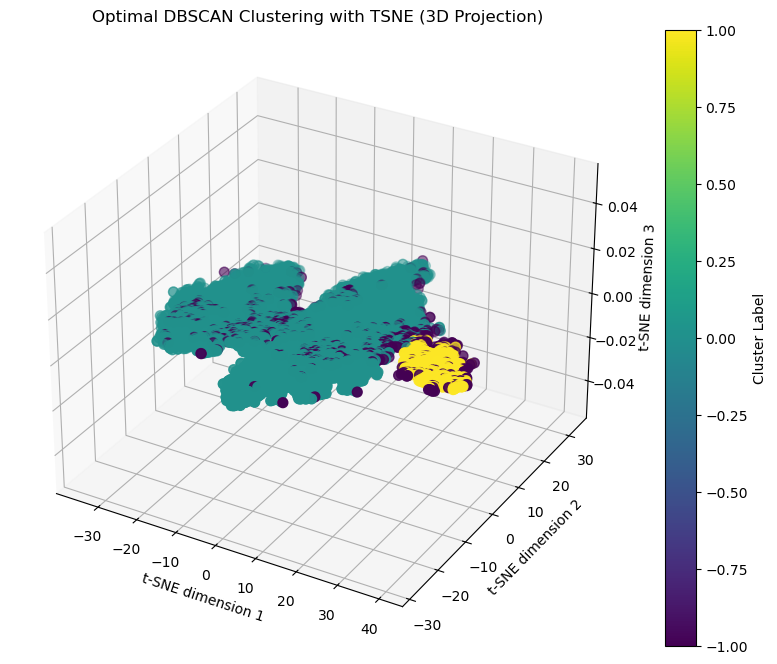

In [274]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components = 3, random_state=42)
X_tsne_3d = tsne.fit_transform(X_resampled)

#3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(X_tsne_3d[:, 0], X_tsne_3d[:, 1], c= optimal_db, cmap='viridis', marker='o', s=50)
plt.title("Optimal DBSCAN Clustering with TSNE (3D Projection)")
plt.xlabel("t-SNE dimension 1")
plt.ylabel("t-SNE dimension 2")
ax.set_zlabel("t-SNE dimension 3")
plt.colorbar(sc, label='Cluster Label')
plt.show()

## Alternative Clustering: Agglomerative Clustering

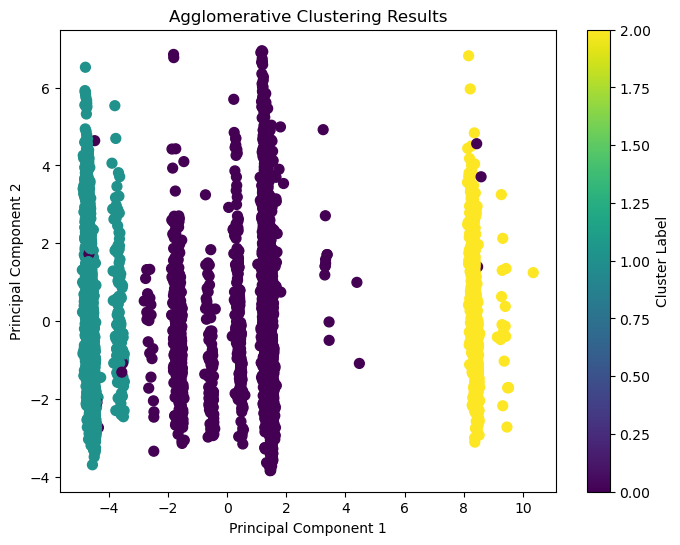

0.42205808407698736
Adjusted Adjusted Rand Index (ARI): -0.007362841372533248


In [510]:
agg_clustering = AgglomerativeClustering(n_clusters=3, linkage='ward')  # 'ward', 'complete', 'average', 'single'

#Fit the model
y_pred = agg_clustering.fit_predict(X_resampled)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_resampled)

# Plot the clusters
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred, cmap='viridis', marker='o', s=50)
plt.title("Agglomerative Clustering Results")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(label='Cluster Label')
plt.show()

sil_score = silhouette_score(X_resampled, y_pred)
print(sil_score)

ari = adjusted_rand_score(y_resampled, y_pred)
print(f'Adjusted Adjusted Rand Index (ARI): {ari}') 

The default ward linkage generated the best looking 2D clustering as we can clearly see three different clusters based on the three different labels of our dataset. There is some overlap with the purple being clustered into the green and yellow clusters, however this seems to be very minimal. 

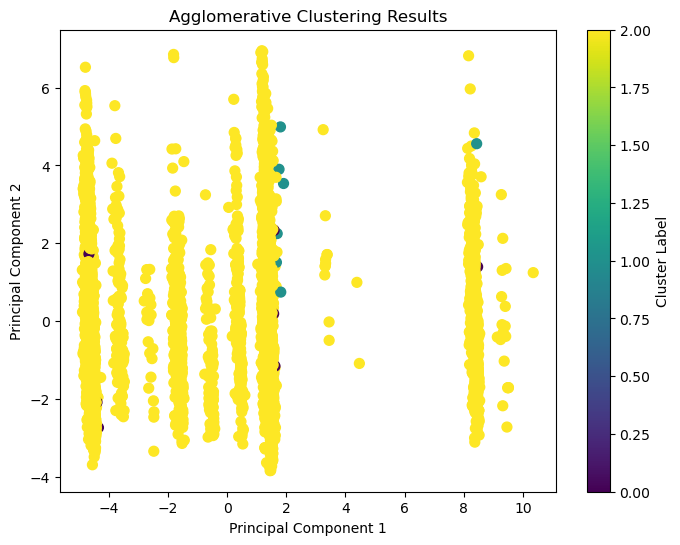

0.6315544053621513
Adjusted Adjusted Rand Index (ARI): 0.0012593455469367162


In [512]:
agg_clustering = AgglomerativeClustering(n_clusters=3, linkage='complete')  # 'ward', 'complete', 'average', 'single'

#Fit the model
y_pred = agg_clustering.fit_predict(X_resampled)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_resampled)

#Plot the clusters
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred, cmap='viridis', marker='o', s=50)
plt.title("Agglomerative Clustering Results")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(label='Cluster Label')
plt.show()

sil_score = silhouette_score(X_resampled, y_pred)
print(sil_score)

ari = adjusted_rand_score(y_resampled, y_pred)
print(f'Adjusted Adjusted Rand Index (ARI): {ari}') 

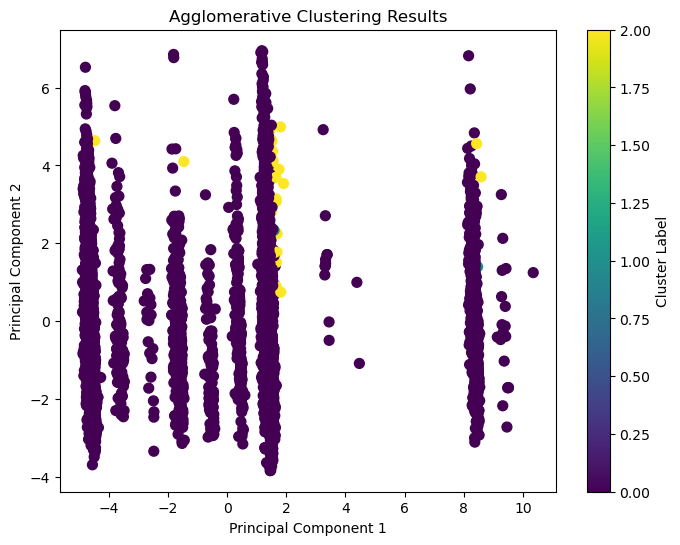

0.5703859050293661
Adjusted Adjusted Rand Index (ARI): 0.002698896439995095


In [513]:
agg_clustering = AgglomerativeClustering(n_clusters=3, linkage='average')  # 'ward', 'complete', 'average', 'single'

#Fit the model
y_pred = agg_clustering.fit_predict(X_resampled)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_resampled)

#Plot the clusters
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred, cmap='viridis', marker='o', s=50)
plt.title("Agglomerative Clustering Results")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(label='Cluster Label')
plt.show()

sil_score = silhouette_score(X_resampled, y_pred)
print(sil_score)

ari = adjusted_rand_score(y_resampled, y_pred)
print(f'Adjusted Adjusted Rand Index (ARI): {ari}') 

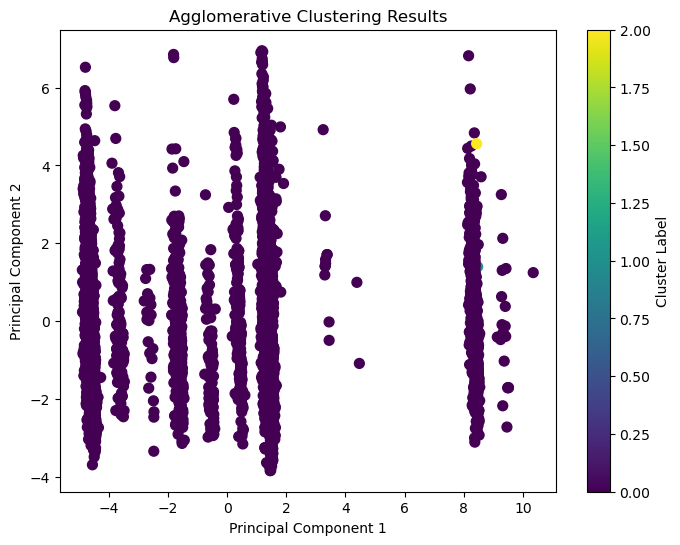

0.620806204824131
Adjusted Adjusted Rand Index (ARI): 0.00010357412702694599


In [515]:
agg_clustering = AgglomerativeClustering(n_clusters=3, linkage='single')  # 'ward', 'complete', 'average', 'single'

#Fit the model
y_pred = agg_clustering.fit_predict(X_resampled)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_resampled)

#Plot the clusters
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred, cmap='viridis', marker='o', s=50)
plt.title("Agglomerative Clustering Results")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(label='Cluster Label')
plt.show()

sil_score = silhouette_score(X_resampled, y_pred)
print(sil_score)

ari = adjusted_rand_score(y_resampled, y_pred)
print(f'Adjusted Adjusted Rand Index (ARI): {ari}') 

In [538]:
best_score = -1
best_ari = -1
best_n_clusters = 0

#Try different values for n_clusters (e.g., from 2 to 10)
for n_clusters in range(2, 11):
    agg_clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage = 'complete')
    y_pred = agg_clustering.fit_predict(X_resampled)
    
    #Compute the silhouette score
    score = silhouette_score(X_resampled, y_pred)

    #Compute the ARI score
    ari = adjusted_rand_score(y_resampled, y_pred)

    #Update the best score and number of clusters
    if score > best_score:
        best_score = score
        best_n_clusters = n_clusters

    if ari > best_ari:
        best_ari = ari
        best_n_clusters = n_clusters

print(f"Optimal number of clusters: {best_n_clusters} with Silhouette Score: {best_score:.3f} with ARI {best_ari:.3f}")

Optimal number of clusters: 2 with Silhouette Score: 0.633 with ARI 0.001


In [182]:
best_score = -1
best_ari = -1
best_n_clusters = 0

#Try different values for n_clusters (e.g., from 2 to 10)
for n_clusters in range(2, 11):
    agg_clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage = 'ward')
    y_pred = agg_clustering.fit_predict(X_resampled)
    
    #Compute the silhouette score
    score = silhouette_score(X_resampled, y_pred)

    #Compute the ARI score
    ari = adjusted_rand_score(y_resampled, y_pred)

    #Update the best score and number of clusters
    if score > best_score:
        best_score = score
        best_n_clusters = n_clusters

    if ari > best_ari:
        best_ari = ari
        best_n_clusters = n_clusters

print(f"Optimal number of clusters: {best_n_clusters} with Silhouette Score: {best_score:.3f} with ARI {best_ari:.3f}")

Optimal number of clusters: 6 with Silhouette Score: 0.422 with ARI 0.010


In [176]:
agg_clustering = AgglomerativeClustering(n_clusters=2, linkage='complete')  # 'ward', 'complete', 'average', 'single'

#Fit the model
y_pred_best_complete = agg_clustering.fit_predict(X_resampled)

pca_3d = PCA(n_components= 3)
X_pca_3d = pca.fit_transform(X_resampled)

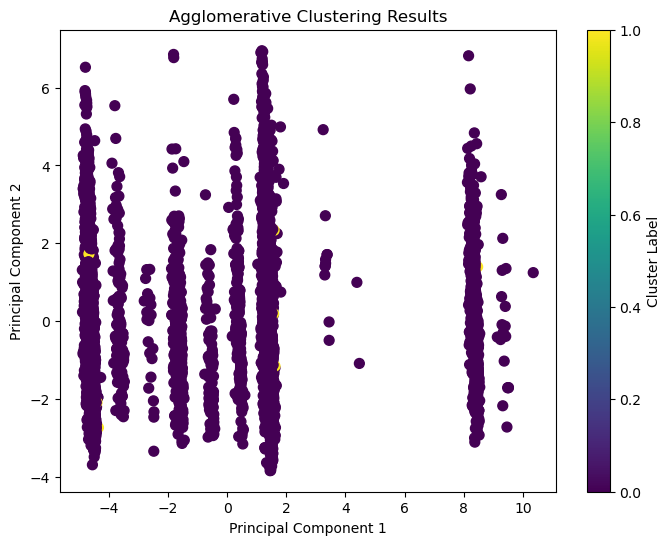

In [180]:
# Plot the clusters
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred_best_complete, cmap='viridis', marker='o', s=50)
plt.title("Agglomerative Clustering Results")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(label='Cluster Label')
plt.show()

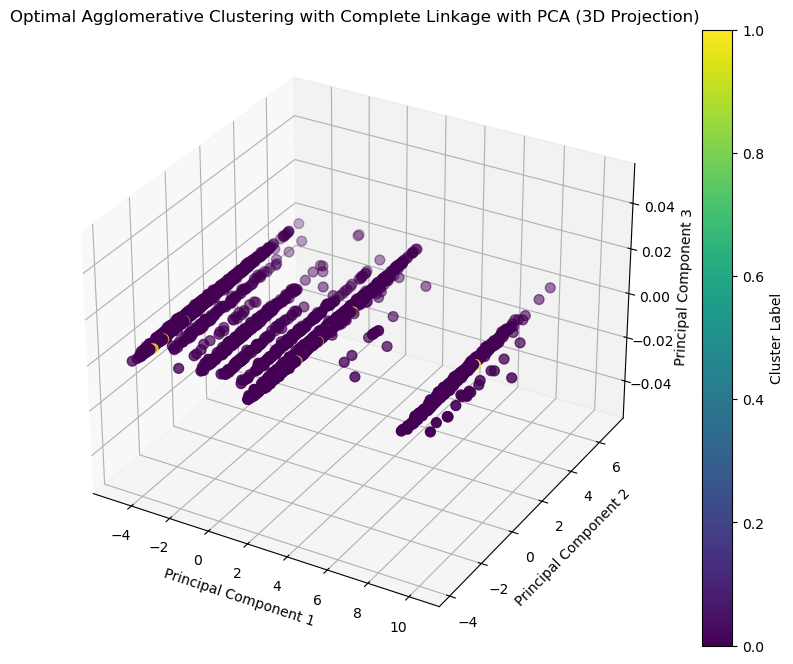

In [178]:
from mpl_toolkits.mplot3d import Axes3D

#3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(X_pca_3d[:, 0], X_pca_3d[:, 1], c= y_pred_best_complete, cmap='viridis', marker='o', s=50)
plt.title("Optimal Agglomerative Clustering with Complete Linkage with PCA (3D Projection)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
ax.set_zlabel("Principal Component 3")
plt.colorbar(sc, label='Cluster Label')
plt.show()

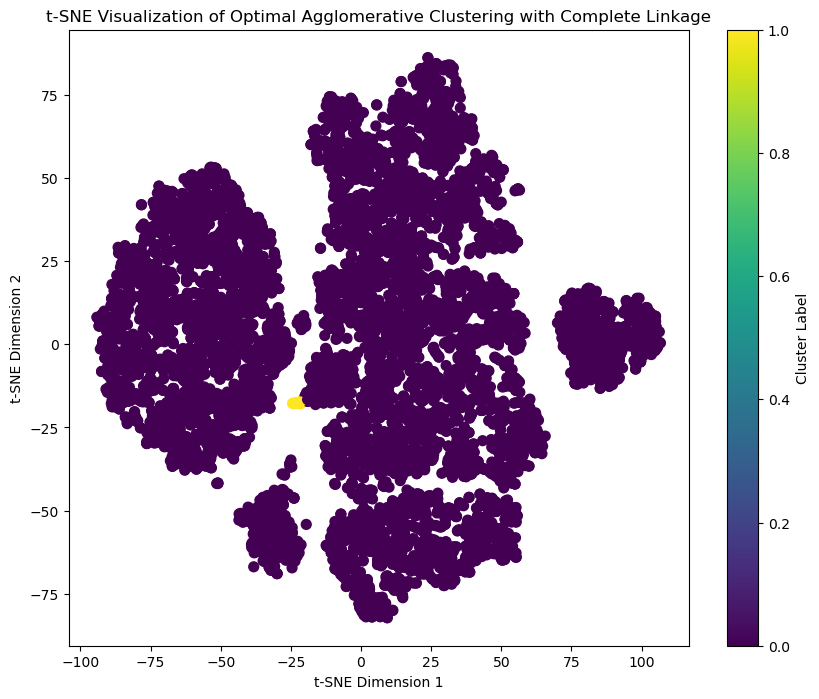

In [188]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_resampled)

# Plotting the 2D t-SNE representation with cluster labels
plt.figure(figsize=(10, 8))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c= y_pred_best_complete, cmap='viridis', s=50)
plt.title('t-SNE Visualization of Optimal Agglomerative Clustering with Complete Linkage')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.colorbar(label='Cluster Label')  # Colorbar to show the cluster labels
plt.show()

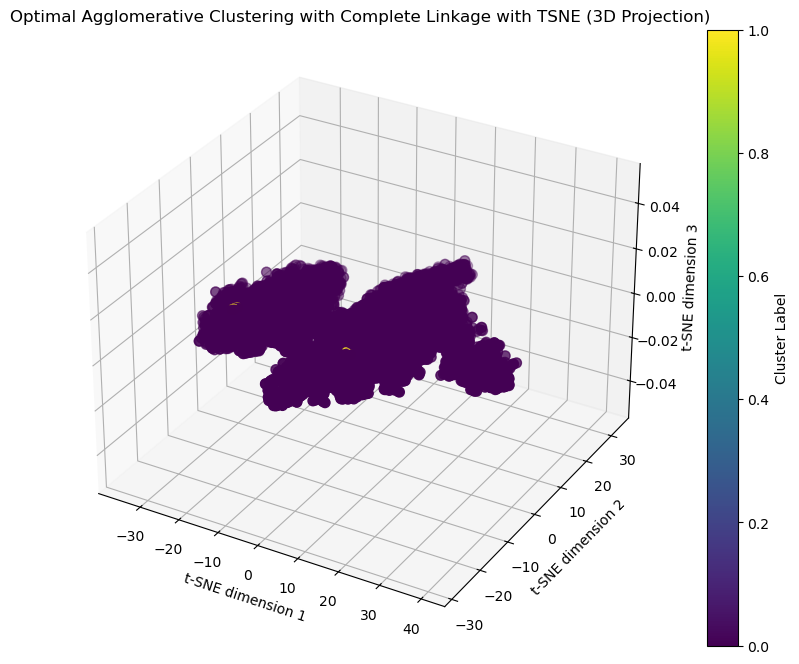

In [189]:
tsne = TSNE(n_components = 3, random_state=42)
X_tsne_3d = tsne.fit_transform(X_resampled)

#3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(X_tsne_3d[:, 0], X_tsne_3d[:, 1], c= y_pred_best_complete, cmap='viridis', marker='o', s=50)
plt.title("Optimal Agglomerative Clustering with Complete Linkage with TSNE (3D Projection)")
plt.xlabel("t-SNE dimension 1")
plt.ylabel("t-SNE dimension 2")
ax.set_zlabel("t-SNE dimension 3")
plt.colorbar(sc, label='Cluster Label')
plt.show()

0.42205808407698736
Adjusted Adjusted Rand Index (ARI): -0.007362841372533248


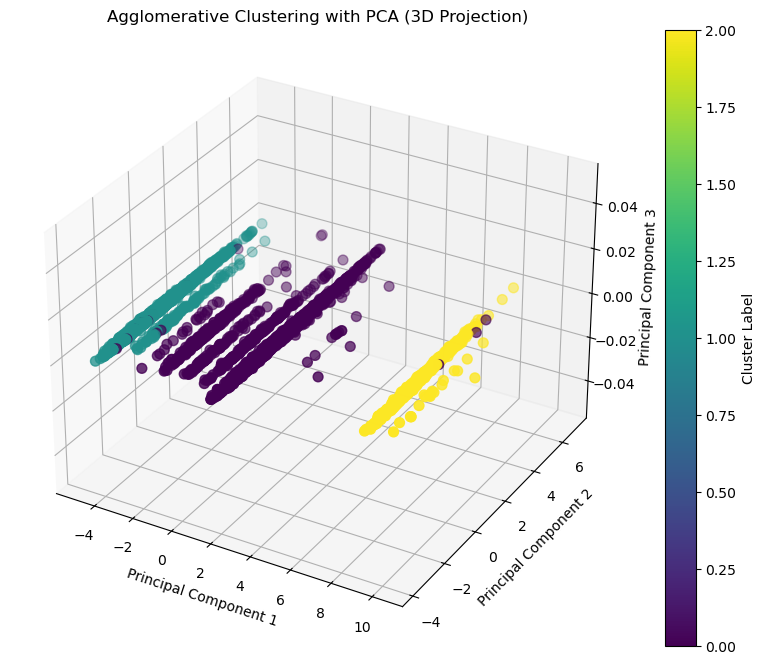

In [152]:
agg_clustering = AgglomerativeClustering(n_clusters=3, linkage='ward')  # 'ward', 'complete', 'average', 'single'

#Fit the model
y_pred_best_ward = agg_clustering.fit_predict(X_resampled)

pca_3d = PCA(n_components= 3)
X_pca_3d = pca.fit_transform(X_resampled)

sil_score = silhouette_score(X_resampled, y_pred_best_ward)
print(sil_score)

ari = adjusted_rand_score(y_resampled, y_pred_best_ward)
print(f'Adjusted Adjusted Rand Index (ARI): {ari}') 

from mpl_toolkits.mplot3d import Axes3D

#3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(X_pca_3d[:, 0], X_pca_3d[:, 1], c= y_pred_best_ward, cmap='viridis', marker='o', s=50)
plt.title("Optimal Agglomerative Clustering with Ward Linkage with PCA (3D Projection)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
ax.set_zlabel("Principal Component 3")
plt.colorbar(sc, label='Cluster Label')
plt.show()

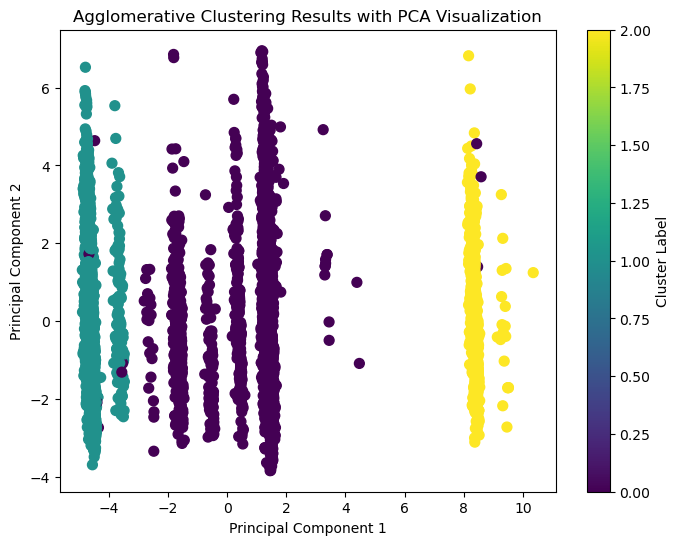

In [206]:
#Plot the clusters
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred_best_ward, cmap='viridis', marker='o', s=50)
plt.title("Agglomerative Clustering Results with PCA Visualization")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(label='Cluster Label')
plt.show()

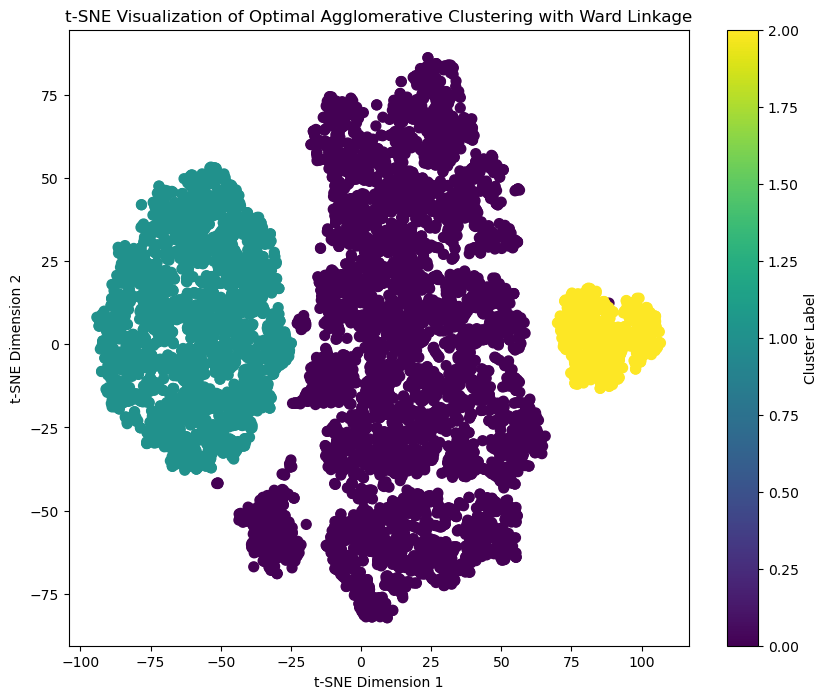

In [162]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_resampled)

# Plotting the 2D t-SNE representation with cluster labels
plt.figure(figsize=(10, 8))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c= y_pred_best_ward, cmap='viridis', s=50)
plt.title('t-SNE Visualization of Optimal Agglomerative Clustering with Ward Linkage')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.colorbar(label='Cluster Label')  # Colorbar to show the cluster labels
plt.show()

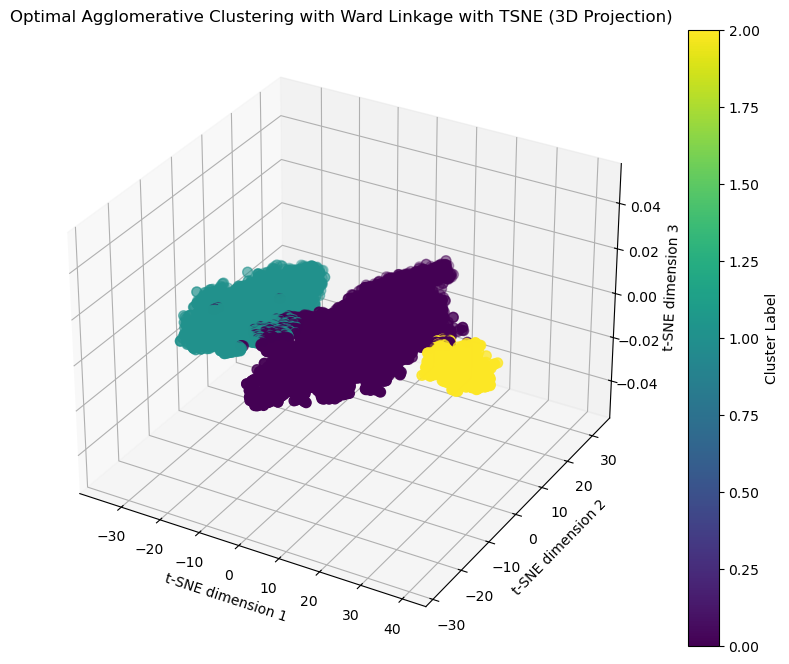

In [160]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components = 3, random_state=42)
X_tsne_3d = tsne.fit_transform(X_resampled)

#3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(X_tsne_3d[:, 0], X_tsne_3d[:, 1], c= y_pred_best_ward, cmap='viridis', marker='o', s=50)
plt.title("Optimal Agglomerative Clustering with Ward Linkage with TSNE (3D Projection)")
plt.xlabel("t-SNE dimension 1")
plt.ylabel("t-SNE dimension 2")
ax.set_zlabel("t-SNE dimension 3")
plt.colorbar(sc, label='Cluster Label')
plt.show()

In [183]:
best_score = -1
best_ari = -1
best_n_clusters = 0

#Try different values for n_clusters (e.g., from 2 to 10)
for n_clusters in range(2, 11):
    agg_clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage = 'single')
    y_pred = agg_clustering.fit_predict(X_resampled)
    
    #Compute the silhouette score
    score = silhouette_score(X_resampled, y_pred)

    #Compute the ARI score
    ari = adjusted_rand_score(y_resampled, y_pred)

    #Update the best score and number of clusters
    if score > best_score:
        best_score = score
        best_n_clusters = n_clusters

    if ari > best_ari:
        best_ari = ari
        best_n_clusters = n_clusters

print(f"Optimal number of clusters: {best_n_clusters} with Silhouette Score: {best_score:.3f} with ARI {best_ari:.3f}")

Optimal number of clusters: 10 with Silhouette Score: 0.792 with ARI 0.001


In [186]:
agg_clustering = AgglomerativeClustering(n_clusters=2, linkage='single')  # 'ward', 'complete', 'average', 'single'

#Fit the model
y_pred_best_single = agg_clustering.fit_predict(X_resampled)

pca_3d = PCA(n_components= 3)
X_pca_3d = pca.fit_transform(X_resampled)

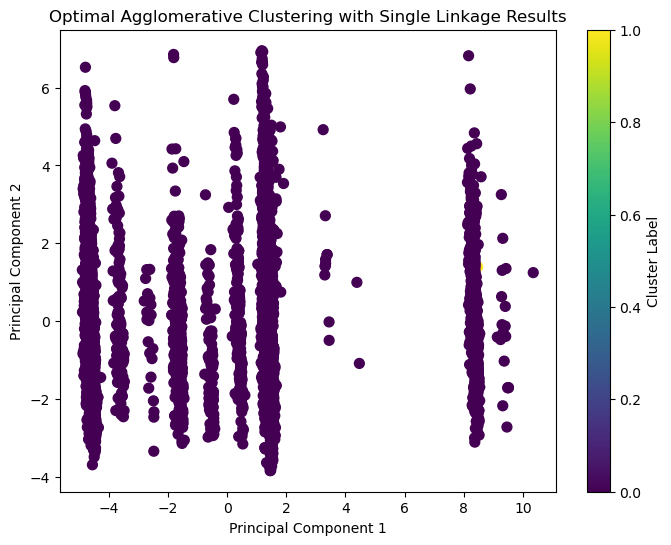

In [191]:
# Plot the clusters
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred_best_single, cmap='viridis', marker='o', s=50)
plt.title("Optimal Agglomerative Clustering with Single Linkage Results")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(label='Cluster Label')
plt.show()

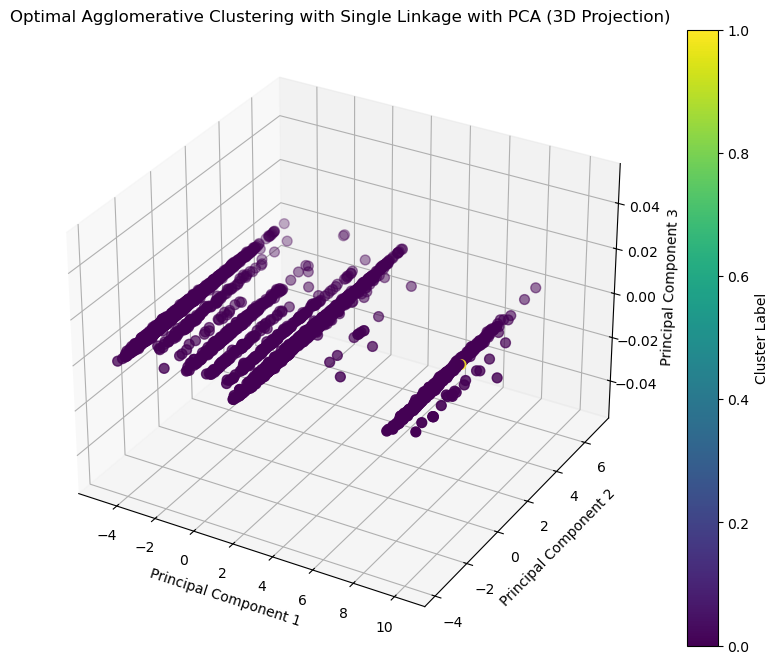

In [192]:
from mpl_toolkits.mplot3d import Axes3D

#3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(X_pca_3d[:, 0], X_pca_3d[:, 1], c= y_pred_best_single, cmap='viridis', marker='o', s=50)
plt.title("Optimal Agglomerative Clustering with Single Linkage with PCA (3D Projection)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
ax.set_zlabel("Principal Component 3")
plt.colorbar(sc, label='Cluster Label')
plt.show()

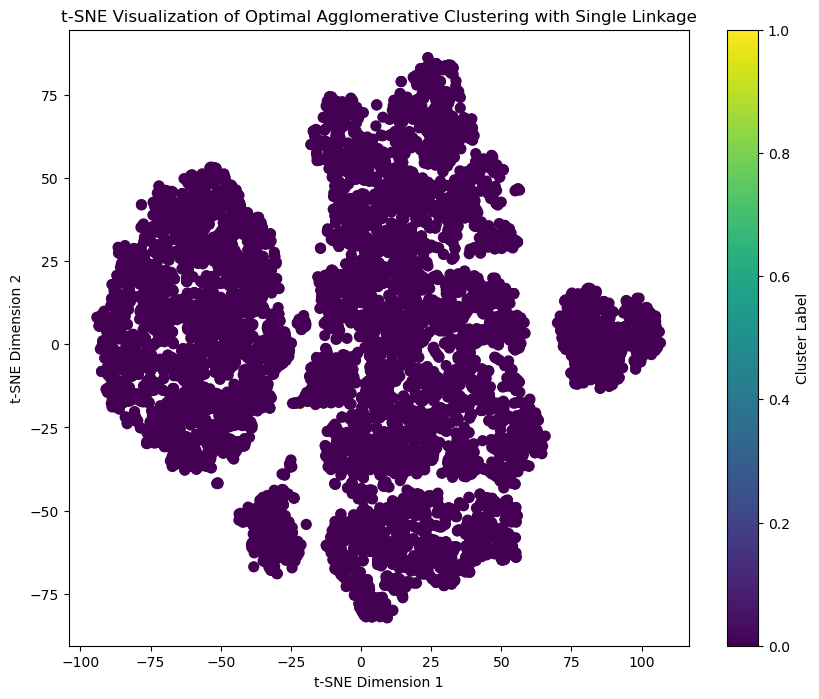

In [284]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_resampled)

# Plotting the 2D t-SNE representation with cluster labels
plt.figure(figsize=(10, 8))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c= y_pred_best_single, cmap='viridis', s=50)
plt.title('t-SNE Visualization of Optimal Agglomerative Clustering with Single Linkage')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.colorbar(label='Cluster Label')  # Colorbar to show the cluster labels
plt.show()

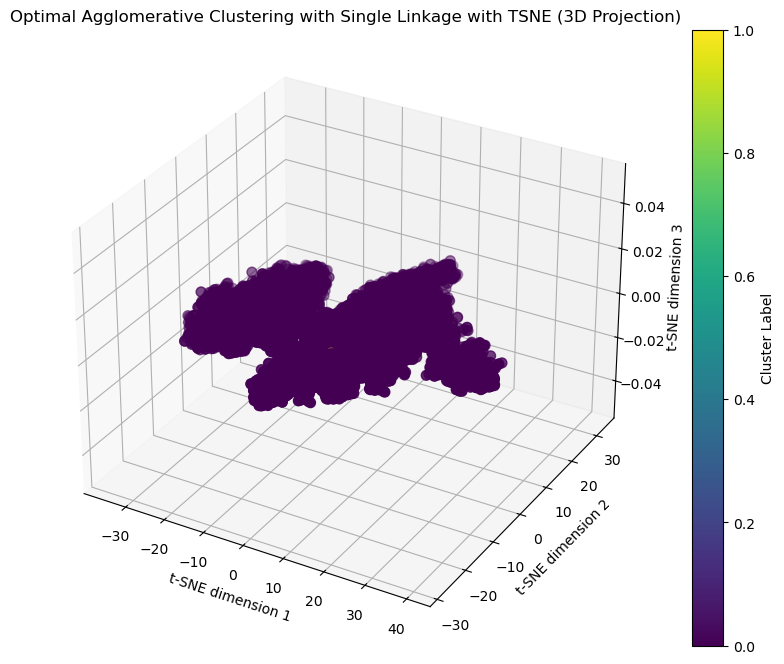

In [287]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components = 3, random_state=42)
X_tsne_3d = tsne.fit_transform(X_resampled)

#3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(X_tsne_3d[:, 0], X_tsne_3d[:, 1], c= y_pred_best_single, cmap='viridis', marker='o', s=50)
plt.title("Optimal Agglomerative Clustering with Single Linkage with TSNE (3D Projection)")
plt.xlabel("t-SNE dimension 1")
plt.ylabel("t-SNE dimension 2")
ax.set_zlabel("t-SNE dimension 3")
plt.colorbar(sc, label='Cluster Label')
plt.show()

## Confusion Matrix of Clusters

Confusion Matrix:
[[ 747  300   77]
 [2320  988  255]
 [3345 1732  412]]


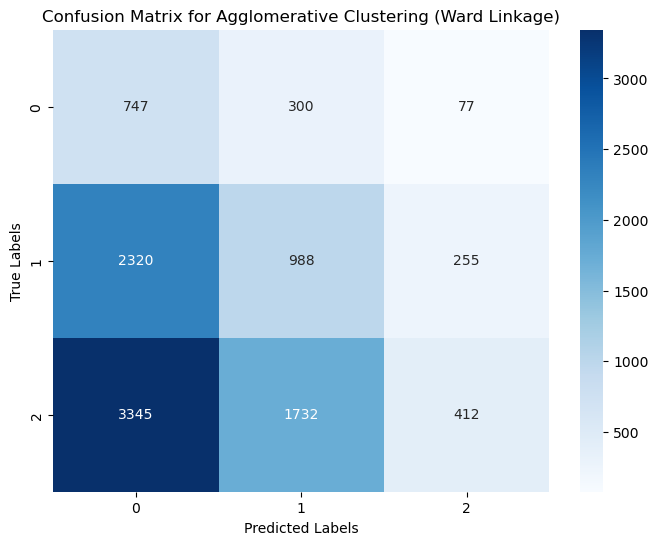

In [215]:
# Step 2: Compute the confusion matrix
conf_matrix = confusion_matrix(y_resampled, y_pred_best_ward)

# Step 3: Print the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Step 4: Visualize the confusion matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", 
            xticklabels=np.unique(y_pred_best_ward), 
            yticklabels=np.unique(y_resampled))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Agglomerative Clustering (Ward Linkage)')
plt.show()

Confusion Matrix:
[[1124    0    0]
 [3562    1    0]
 [5489    0    0]]


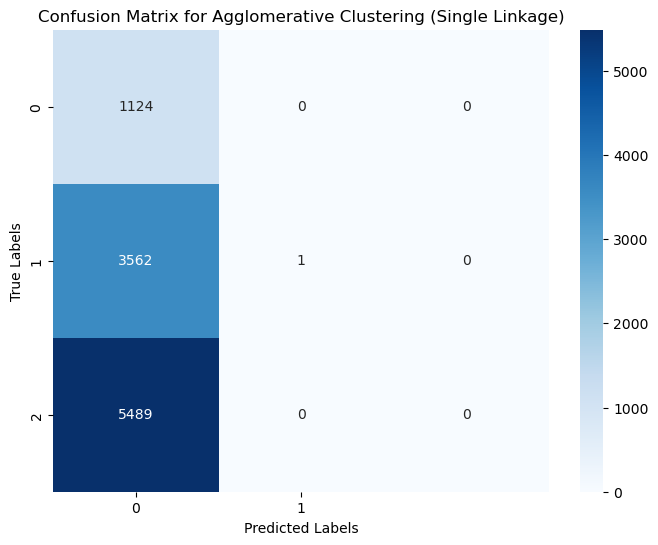

In [225]:
# Step 2: Compute the confusion matrix
conf_matrix = confusion_matrix(y_resampled, y_pred_best_single)

# Step 3: Print the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Step 4: Visualize the confusion matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", 
            xticklabels=np.unique(y_pred_best_single), 
            yticklabels=np.unique(y_resampled))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Agglomerative Clustering (Single Linkage)')
plt.show()

Confusion Matrix:
[[1121    3    0]
 [3557    6    0]
 [5484    5    0]]


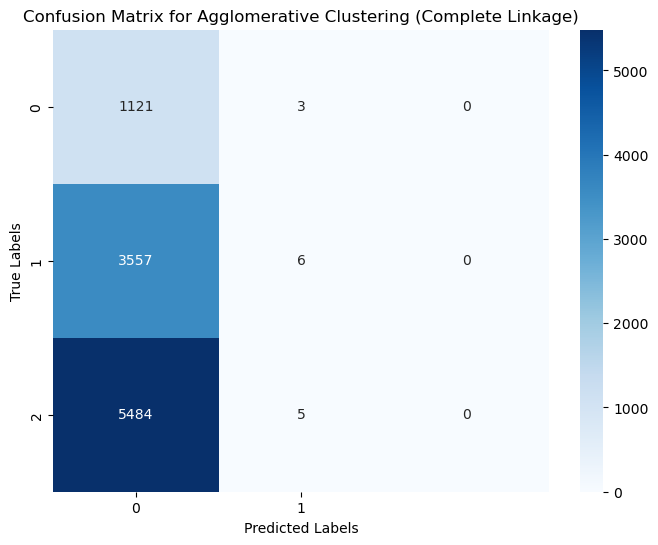

In [223]:
#Compute the confusion matrix
conf_matrix = confusion_matrix(y_resampled, y_pred_best_complete)

#Print the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

#Visualize the confusion matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", 
            xticklabels=np.unique(y_pred_best_complete), 
            yticklabels=np.unique(y_resampled))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Agglomerative Clustering (Complete Linkage)')
plt.show()

Confusion Matrix:
[[ 787  337    0]
 [2511 1052    0]
 [3535 1954    0]]


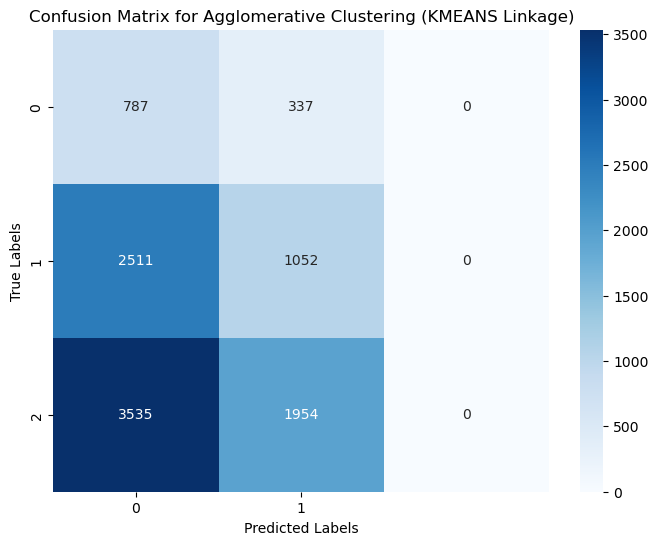

In [229]:
#Compute the confusion matrix
conf_matrix = confusion_matrix(y_resampled, labels)

#Print the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

#Visualize the confusion matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", 
            xticklabels=np.unique(labels), 
            yticklabels=np.unique(y_resampled))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Agglomerative Clustering (KMEANS Linkage)')
plt.show()

Confusion Matrix:
[[   0    0    0    0]
 [ 135  936   53    0]
 [ 301 3055  207    0]
 [ 245 4874  370    0]]


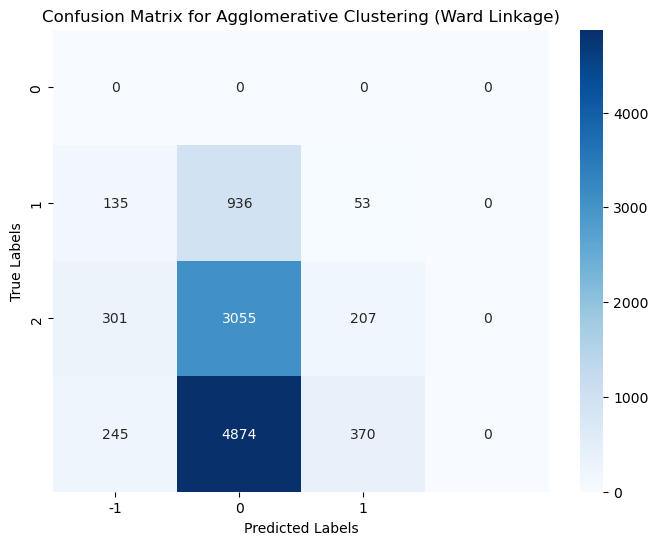

In [233]:
#Compute the confusion matrix
conf_matrix = confusion_matrix(y_resampled, optimal_db)

#Print the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

#Visualize the confusion matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", 
            xticklabels=np.unique(optimal_db), 
            yticklabels=np.unique(y_resampled))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Agglomerative Clustering (Ward Linkage)')
plt.show()

## Attempts of MDS

In [ ]:
#Plot MDS with K-Means clusters
plt.figure(figsize=(10, 8))
plt.scatter(X_mds[:, 0], X_mds[:, 1], c = labels, cmap='viridis', s=50)

# Add labels
plt.title("K-Means Clustering in MDS Space")
plt.xlabel("MDS Dimension 1")
plt.ylabel("MDS Dimension 2")
plt.colorbar(label='Cluster Label')

plt.show()